In [1]:
import xml.etree.ElementTree as ET
import os
import numpy as np

points_list = [] # list of point sequences
points_lengths = [] # list of lengths of point sequences

xmax = 0
ymax = 0

# Iterate through xml files
file_num = 0
folders = os.listdir('original')
for folder in folders:
    samples = os.listdir('original/' + folder)
    for sample in samples:
        file_num += 1
        tree = ET.parse('original/' + folder + '/' + sample + '/strokesz.xml')
        root = tree.getroot()

        # Save the x-y-EOS series as another numpy array, put it in list
        points = []
        for stroke in root.find('StrokeSet').findall('Stroke'):
            point_set = stroke.findall('Point')
            end = len(point_set) - 1
            for i, point in enumerate(point_set):
                x = float(point.get('x'))
                y = float(point.get('y'))
                
                xmax = max(xmax, x)
                ymax = max(ymax, y)
                eos = float(i == end)
                points.append([x, y, eos])
    point_series = np.array(points, dtype=np.float64)
    points_list.append(point_series)
    points_lengths.append(point_series.shape[0])
    
print('Done parsing')

Done parsing


In [2]:
import torch
import random

In [13]:
class GeneratorCell(torch.nn.Module):
    def __init__(self, hidden_size, mixture_size):
        super(GeneratorCell, self).__init__()

        self.gru = torch.nn.GRU(input_size=3, hidden_size=hidden_size, batch_first=True)
        self.hidden_size= hidden_size
        self.mixture_size = mixture_size

        # for generating mixture weights
        self.linear1 = torch.nn.Linear(hidden_size, mixture_size)

        # for generating means
        self.linear2 = torch.nn.Linear(hidden_size, 2*mixture_size) 
        
        # for generating standard deviations
        self.linear5 = torch.nn.Linear(hidden_size, 2*mixture_size) 

        # for generating correlations
        self.linear3 = torch.nn.Linear(hidden_size, mixture_size) 

        # for generating EOS probability
        self.linear4 = torch.nn.Linear(hidden_size, 1)

    def forward(self, input_batch, seq_length):
        batch_size = input_batch.size()[0]
        mdn_output_batch = torch.zeros(batch_size, seq_length, 6*self.mixture_size + 1)
        hidden = torch.zeros(1, batch_size, self.hidden_size, dtype=torch.double)
        output, hidden = self.gru(input_batch, hidden)
        for i in range(seq_length):
            mdn_input = output[:, i, :]
            
            gmm_weights = torch.nn.functional.softmax(self.linear1(mdn_input), dim=1)
            gmm_means = 20*self.linear2(mdn_input)
            gmm_stds = 10*torch.exp(self.linear5(mdn_input))
            gmm_corrs = torch.tanh(self.linear3(mdn_input))
            eos_prob = torch.sigmoid(self.linear4(mdn_input))
            mdn_output = torch.cat((gmm_weights, gmm_means, gmm_stds, gmm_corrs, eos_prob), 1)
            mdn_output_batch[:, i, :] = mdn_output
            
        return mdn_output_batch
    
    # Given some (x, y, EOS), return the distribution parameters for (delta_x, delta_y, EOS) and the next hidden state
    def get_next(self, input, hidden):
        output, hidden = self.gru(input.view(1, 1, 3), hidden)
        
        # get rid of sequence index in output
        output = output.squeeze(1)

        gmm_weights = torch.nn.functional.softmax(self.linear1(output), dim=1)
        gmm_means = 20*self.linear2(output)
        gmm_stds = 10*torch.exp(self.linear5(output))
        gmm_corrs = torch.tanh(self.linear3(output))
        eos_prob = torch.sigmoid(self.linear4(output))
        mdn_output = torch.cat((gmm_weights, gmm_means, gmm_stds, gmm_corrs, eos_prob), 1)
            
        return mdn_output, hidden

In [37]:
def log_likelihood_batched(input_batch, output_batch, min_length, mixture_size, batch_size):
    logprob = 0 # mean log probability of input data across batches
    
    # iterate through data points in sequence
    for seq_index in range(min_length - 1):
        data_point_batch = input_batch[:, seq_index + 1] # batch of next x-y-EOS values
        # iterate through Gaussians in mixture model
        prob = 0
        for k in range(mixture_size):
            # mixing coefficient lambda_k
            lambda_k = output_batch[:, seq_index, k]

            mu_x = output_batch[:, seq_index, mixture_size + k] + input_batch[:, seq_index, 0]
            mu_y = output_batch[:, seq_index, 2*mixture_size + k] + input_batch[:, seq_index, 1]
            
            loc = torch.stack([mu_x, mu_y]).view(-1, 2) #for passing to multivariate normal
            sigma_x = output_batch[:, seq_index, 3*mixture_size + k]
            sigma_y = output_batch[:, seq_index, 4*mixture_size + k]
            correlation = output_batch[:, seq_index, 5*mixture_size + k]

            cov = correlation*sigma_x*sigma_y
            cov_mat = torch.zeros((batch_size, 2, 2), dtype=torch.double)
            cov_mat[:, 0, 0] = sigma_x**2 + 0.01*torch.ones(batch_size)
            cov_mat[:, 0, 1] = cov
            cov_mat[:, 1, 0] = cov
            cov_mat[:, 1, 1] = sigma_y**2
            
            gaussian = torch.distributions.multivariate_normal.MultivariateNormal(loc, cov_mat)
            prob += lambda_k*torch.exp(gaussian.log_prob(data_point_batch[:, 0:2].double()))
        logprob += torch.sum(torch.log(prob + 0.001*torch.ones(batch_size)))/batch_size
        eos = data_point_batch[:, 2]
        not_eos = torch.ones(batch_size) - eos
        logprob += torch.sum(eos*torch.log(output_batch[:, seq_index, 6*mixture_size]))/batch_size #EOS probability
        logprob += torch.sum(not_eos*torch.log(1 - output_batch[:, seq_index, 6*mixture_size]))/batch_size #not-EOS probability
            
    return logprob/min_length

In [40]:
# Training loop
n_epochs = 100
n_iters = 50
hidden_size = 16
mixture_size = 2
batch_size = 50

model = GeneratorCell(hidden_size, mixture_size).double()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

losses = np.zeros(n_epochs) # For plotting

indices = list(range(len(points_list))) # Indices for random sampling (for batches)

In [41]:
for epoch in range(n_epochs):
    for iter in range(n_iters):
        print('Epoch: ' + str(epoch) + ' Iteration: ' + str(iter))
        index_list = random.sample(indices, batch_size) # random sampling of indices
        min_length = min([points_lengths[i] for i in index_list]) # list of sequence lengths
        min_length = min(1000, min_length)
        input_batch = torch.autograd.Variable(torch.tensor([points_list[i][0:min_length] for i in index_list], dtype=torch.double))
        
        output_batch = model.forward(input_batch, min_length)

        optimizer.zero_grad()
        loss = -log_likelihood_batched(input_batch, output_batch, min_length, mixture_size, batch_size)
        loss.backward()
        optimizer.step()
        
        print('Loss: ' + str(loss.data))

        losses[epoch] += loss.data

Epoch: 0 Iteration: 0
Loss: tensor(inf, dtype=torch.float64)
Epoch: 0 Iteration: 1


RuntimeError: cholesky_cpu: For batch 0: U(1,1) is zero, singular U.

Next we have a plotter script to see what our model generates

In [20]:
import matplotlib.pyplot as plt

In [34]:
output_x = [895] # list of x outputs. this is the initial x
output_y = [992] # list of y outputs. this is the initial y
eos = 0 # does the previous output correspond to an eos
hidden = torch.zeros((1, 1, hidden_size), dtype=torch.double)
for i in range(500):
    input = torch.tensor([output_x[-1], output_y[-1], eos], dtype=torch.double)
    dist, hidden = model.get_next(input, hidden)
    dist = dist.squeeze(0)
    sample = torch.zeros(2, dtype=torch.double)
    for k in range(mixture_size):
        # mixing coefficient lambda_k
        lambda_k = dist[k]

        mu_x = dist[mixture_size + k] + input[0]
        mu_y = dist[2*mixture_size + k] + input[1]

        loc = torch.tensor([mu_x, mu_y]) #for passing to multivariate normal
        sigma_x = 10*dist[3*mixture_size + k]
        sigma_y = 10*dist[4*mixture_size + k]
        correlation = dist[5*mixture_size + k]

        cov = correlation*sigma_x*sigma_y
        cov_mat = torch.zeros((2, 2), dtype=torch.double)
        cov_mat[0, 0] = sigma_x**2 + 0.01
        cov_mat[0, 1] = cov
        cov_mat[1, 0] = cov
        cov_mat[1, 1] = sigma_y**2

        gaussian = torch.distributions.multivariate_normal.MultivariateNormal(loc, cov_mat)
        sample += lambda_k*gaussian.rsample()
    output_x.append(sample[0].data)
    output_y.append(sample[1].data)
    
    b = torch.distributions.Bernoulli(dist[6*mixture_size])
    eos = b.sample().data

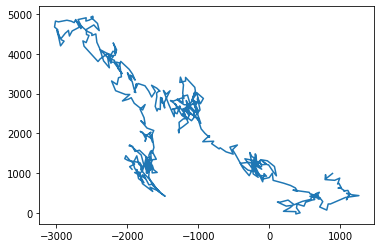

In [35]:
plt.plot(output_x, output_y)

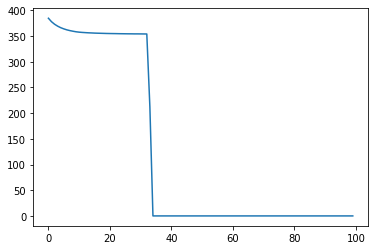

In [36]:
plt.plot(losses)
plt.show()